# Telepromter adatok elemzése - 3. Házi Data Science Verseny - Jákob Tamás

## 0. Bevezető lépések

### 0.1 CSV konvertálása parquet-re.

Cél: fájlméret csökkentése

In [8]:
%%timeit -n 1 -r 1
import polars as pl
def scan_and_save() -> None:
    '''
    Függvény, ami beolvassa a megfelelő csv fájlt és a hatékonyabb parquet formátumba menti anélkül, hogy betöltené a memóriába.
    '''
    # Nagy CSV beolvasása LazyFrame-ként
    lf = pl.scan_csv("teleprompter_hashed_fixed.csv", separator=";").sink_parquet("tele.parquet", compression="zstd")
    print("Fájlméret csökkent 1Gb-ról 93Mb-ra")
    return None
scan_and_save()

Fájlméret csökkent 1Gb-ról 93Mb-ra
9.96 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


### 0.2 Importok

In [9]:
#!pip install plotnine
#!pip install pyarrow
#!pip install lxml
#pip install pycaret
#!pip install networkx
#!pip install ipywidgets
#!pip install umap-learn

In [10]:
from plotnine import (ggplot, aes, geom_histogram, geom_path, theme_minimal, 
                    labs, annotate, geom_point, geom_smooth, scale_fill_manual, geom_bar, 
                    coord_flip, theme,element_text, geom_text, position_stack, geom_line,
                    ylim, scale_fill_brewer, geom_col, scale_fill_gradient, geom_vline, geom_hline)
import numpy as np
import polars as pl
import pandas as pd
import pyarrow
from pycaret.classification import *
from pycaret.clustering import *
import umap
from scipy.stats import mannwhitneyu
from io import BytesIO
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import ipywidgets as widgets
from IPython.display import display
import plotly
import plotly.io as pio
pio.renderers.default = "iframe"

pd.set_option('display.max_rows', 101)
pd.set_option('display.max_columns', 100)
pd.set_option('display.expand_frame_repr', False)

np.random.seed(42)

### 0.3 Beugró kérdések megválaszolása

A versenyre történő nevezés véglegesítéséhez az alábbi három kérdést kellett megválaszolni:
- Hány felhasználó kezdte el a trialt az adott időszakban?
- Hány felhasználó konvertált és hány felhasználó mondta le végül a trialt?

In [11]:
df = pl.scan_parquet("tele.parquet")

#Összes user, aki elkezdte a trialt:
user_count = (
    df.filter(pl.col("event") == "trial_started_event")  
    .select(pl.col("distinct_id").n_unique()).collect().item()
)

#userek, akik konvertáltak
trial_converted_event_users = (
    df.filter(pl.col("event") == "trial_converted_event")  
    .select(pl.col("distinct_id").n_unique()).collect().item()    
)
#userek, akik lemondták a trialt
trial_cancelled_event_users = (
    df.filter(pl.col("event") == "trial_cancelled_event")  
    .select(pl.col("distinct_id").n_unique()).collect().item() 
)
print(f"Az összes user, aki elkezdte a triált: {user_count}.")
print(f"A userek száma, akik végül konvertáltak a vizsgált időszakban: {trial_converted_event_users}.")
print(f"A userek száma, akik végül nem konvertáltak a vizsgált időszakban: {trial_cancelled_event_users}.")

Az összes user, aki elkezdte a triált: 19591.
A userek száma, akik végül konvertáltak a vizsgált időszakban: 4488.
A userek száma, akik végül nem konvertáltak a vizsgált időszakban: 16331.


In [12]:
print(f"Memóriahasználat: {df.collect().estimated_size()/1_000_000_000:.2f} gigabájt")

Memóriahasználat: 1.68 gigabájt


## 1. Első formázások

Az adatok módosítása a későbbi elemzésekhez az alábbi lépésekkel:
- epoch átalakítása dátummá
- "time_since_first_event" : oszlop készítése: egyes eventek dátuma a belépéstől számítva, userenként
- idő differenciák létrehozása "time_since_first_event" oszlopból -> nap, óra, perc, másodperc

Az adatok betöltése a merevlemezről:

In [13]:
df = pl.scan_parquet("tele.parquet")
df = df.with_columns(
    pl.from_epoch(pl.col("event_time"), time_unit="s").alias("date")
).drop("event_time")

Előállítom a "time_since_first_event" oszlopot, ami az események megtöténtét a felhasználónkénti első eseménytől számolja.

In [14]:
df = df.with_columns(
    (pl.col("date") - pl.col("date").min().over("distinct_id")).alias("time_since_first_event")
)

In [15]:
df = df.with_columns([
    ((pl.col("time_since_first_event").dt.total_seconds() // (60 * 60 * 24))).cast(pl.Int32).alias("days"),
    ((pl.col("time_since_first_event").dt.total_seconds() // (60 * 60))).cast(pl.Int32).alias("hours"),
    ((pl.col("time_since_first_event").dt.total_seconds() // (60)) ).cast(pl.Int32).alias("minutes"),
    (pl.col("time_since_first_event").dt.total_seconds()).cast(pl.Int32).alias("seconds")
]).collect()

In [16]:
df.head()

event,distinct_id,os_version,country_code,date,time_since_first_event,days,hours,minutes,seconds
str,str,str,str,datetime[μs],duration[μs],i32,i32,i32,i32
"""Homescreen""","""$device:user_60299947607494""","""18.1.1""","""RU""",2025-02-02 03:12:37,6d 16h 52m 19s,6,160,9652,579139
"""Player_screen""","""$device:user_60299947607494""","""18.1.1""","""RU""",2025-02-02 03:12:37,6d 16h 52m 19s,6,160,9652,579139
"""updateScript""","""$device:user_60299947607494""","""18.1.1""","""RU""",2025-02-02 03:12:38,6d 16h 52m 20s,6,160,9652,579140
"""Homescreen""","""$device:user_60299947607494""","""18.1.1""","""RU""",2025-02-02 03:12:39,6d 16h 52m 21s,6,160,9652,579141
"""$ae_session""","""$device:user_60299947607494""","""18.1.1""","""RU""",2025-02-02 03:12:40,6d 16h 52m 22s,6,160,9652,579142


In [17]:
mem_usage = df.estimated_size()
print(f"Memóriahasználat: {mem_usage/1024/1024/1024:.2f} Gb")

Memóriahasználat: 2.20 Gb


## 2. Felhasználók számának elemzése

Elemzem a felhasználókat aszerint, hogy mennyi ideje (napja) használják az appot.

In [18]:
days_df = df.group_by("distinct_id").agg(pl.col("days").max().alias("max_days")).to_pandas()

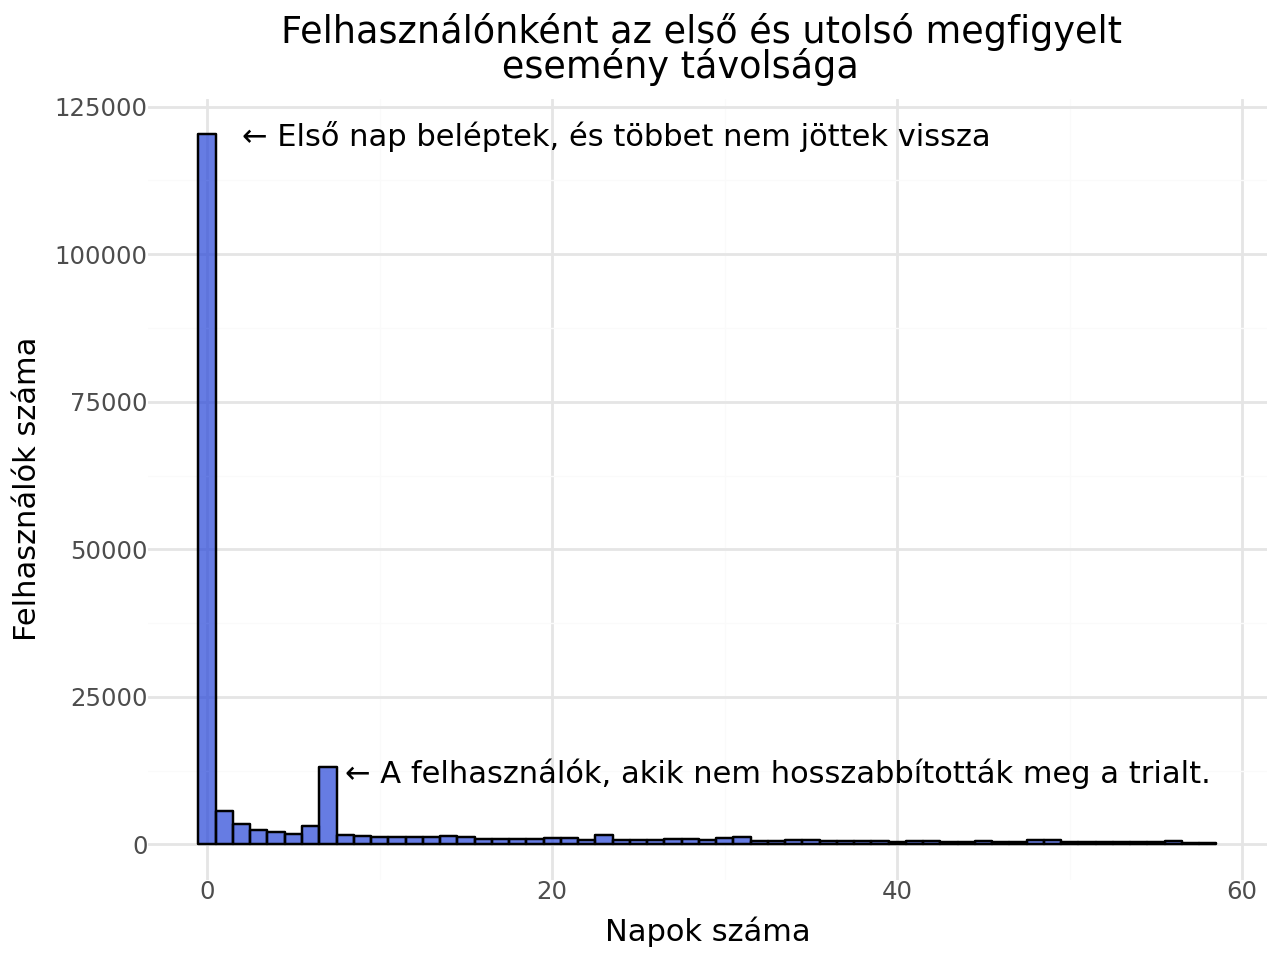

In [19]:
max_days_plot = (
    ggplot(days_df, aes(x="max_days")) +
    geom_histogram(binwidth=1, fill="#2544d8", color="black", alpha=0.7) +
    theme_minimal() +
    labs(title="Felhasználónként az első és utolsó megfigyelt \n                   esemény távolsága", x="Napok száma", y="Felhasználók száma") +
    annotate("text", x=2, y=120000, label="← Első nap beléptek, és többet nem jöttek vissza", ha="left") +
    annotate("text", x=8, y=12000, label="← A felhasználók, akik nem hosszabbították meg a trialt.", ha="left")
)
display(max_days_plot)

In [20]:
max_days_plot.save("./images/max_days_plot.png", dpi=300, transparent=True)

Megfigyelés 1: 120.000+ felhasználó első nap letöltötte az appot, és többet nem indította el.

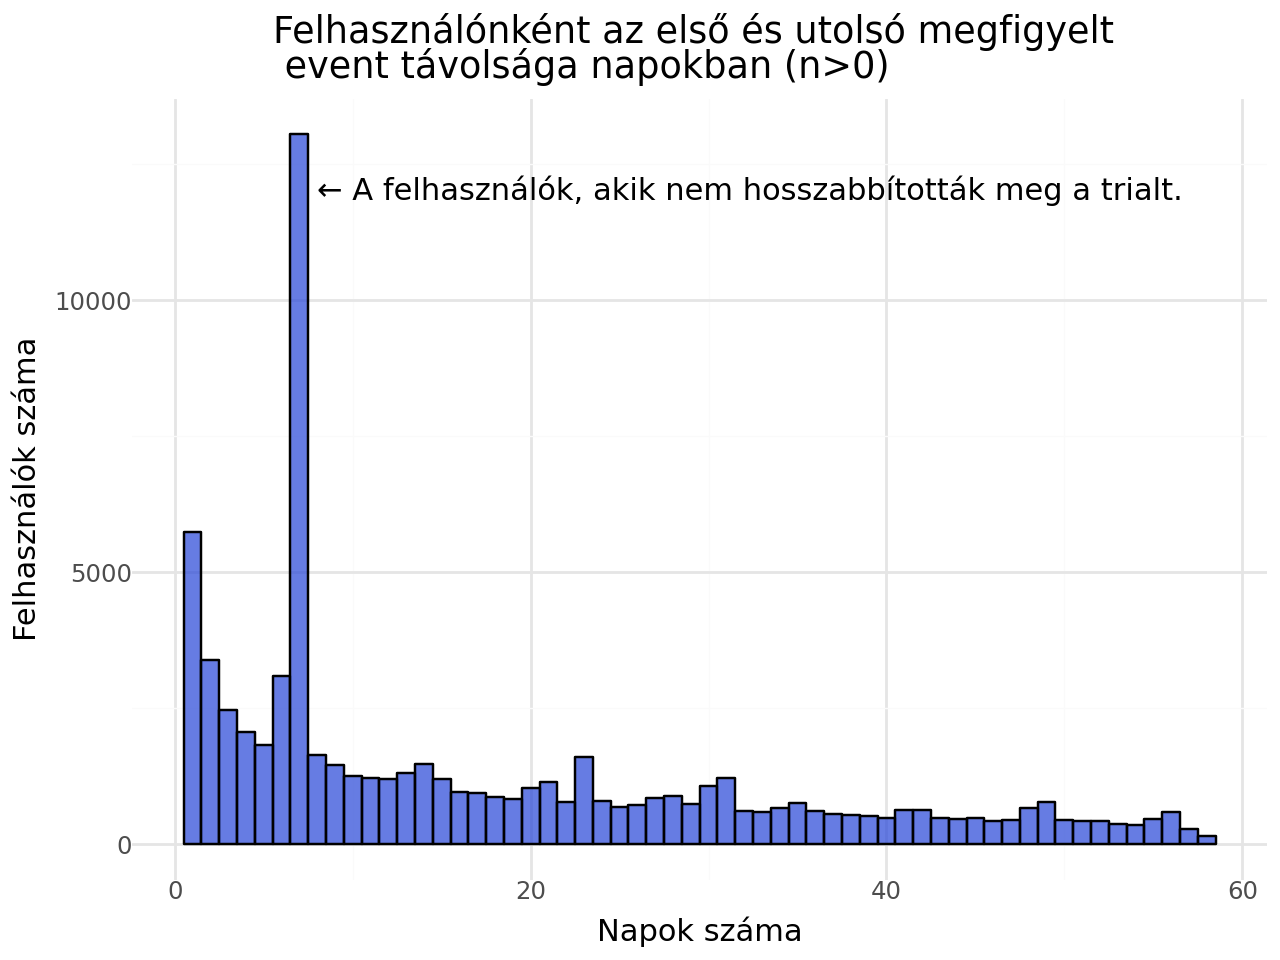

In [21]:
max_days_plot_nem_0 = (
    ggplot(days_df[days_df["max_days"]>0], aes(x="max_days")) +
    geom_histogram(binwidth=1, fill="#2544d8", color="black", alpha=0.7) +
    theme_minimal() +
    labs(title="Felhasználónként az első és utolsó megfigyelt \n event távolsága napokban (n>0)", x="Napok száma", y="Felhasználók száma") +
    annotate("text", x=8, y=12000, label="← A felhasználók, akik nem hosszabbították meg a trialt.", ha="left")
)
display(max_days_plot_nem_0)

Megfigyelés 2: ~6.000 felhasználó belépett a 2. napon is, de további ~15.000 felhasználó a 7 napon, a trial végén lépett be utoljára.
Az elemzés irányának annak kell lennie, 
- egyrészt miért csökken az érdeklődés napról napra a trial időszakban, miért nem lépnek be a harmadik, negyedik, további napokon.
- másrészt sok felhasználó a hetedik napon lépett be utoljára, a "trial_cancelled_event" megtekintése nélkül is látható, hogy nem fizettek elő.
Ez a két csoport megtartása a legfőbb kihívás.

In [22]:
max_days_plot_nem_0.save("./images/max_days_plot_nem_0.png", dpi=300, transparent=True)

## 3. A DataFrame szűrése az alábbi szempontok szerint:
Cél: A trial időszak utáni konverziós ráta növelése, okainak felderítése


A fenti cél miatt érdektelenek bizonyos a userek és eventek:
- A vizsgált időszak előtt regisztrált userek, hiába vannak eventek az időszakon belül, hiszen a kezdeti vielkedési mintájuk nem látható. **Az első benyomás mindig a legfontosabb elv használata.** Feloldása: azon userek törlése az adatból, akikhez nem tartozik start event (2.1. fejezet). 
- A vizsgált időszak után lejáró trial időszakhoz tartozó userek adatai, mivel nem tudjuk, hogy előfizettek-e. Az adatcsomag nagy, véleményem szerint a **cenzorált adatok megtartása csak fölösleges zajt okozna**. Feloldása: azon userek törlése az adatból, akiknek vizsgált időszak vége előtt kevesebb, mint 7 nappal kezdték az app használatát (2.2. fejezet).

### Csak azon felhasználók megtartása, akik trial periódusuk kezdetét és végét is látjuk

### 3.1. Felhasználók törlése az adatból.

In [23]:
del days_df
nyers_dfben_userek = df["distinct_id"].n_unique()
print(f"Nyers adatokban az összes benne szereplő egyedi felhasználó száma: {nyers_dfben_userek}")
nyers_dfben_country_code = df["country_code"].n_unique()
print(f"Nyers adatokban az összes benne szereplő egyedi country_code száma: {nyers_dfben_country_code}")

users_with_start = set(df.filter(pl.col("event") == "trial_started_event")["distinct_id"].to_list())
users_with_convert = set(df.filter(pl.col("event") == "trial_converted_event")["distinct_id"].to_list())
users_with_cancel = set(df.filter(pl.col("event") == "trial_cancelled_event")["distinct_id"].to_list())
print(f"Felhasználók száma, akik elkezdték a trial: {len(users_with_start)}")
print(f"Felhasználók száma, akik előfizettek: {len(users_with_convert)}")
print(f"Felhasználók száma, akik lemondták a trialt: {len(users_with_cancel)}")

# Kiválasztjuk azokat a user ID-ket, akiknek van "convert" vagy "calcelled" eventjük
users_with_stop_or_end = set(df.filter(pl.col("event").is_in(["trial_converted_event", "trial_cancelled_event"]))["distinct_id"].to_list())
print(f"Trial stop vagy cancel eventes felhasználók száma: {len(users_with_stop_or_end)}")

# Közös user ID-k megtalálása
valid_users = users_with_start & users_with_stop_or_end 
start_and_convert_users = users_with_start & users_with_convert
start_and_cancel_users = users_with_start & users_with_cancel
print(f"Elemzés szempontjából valid userek száma: {len(valid_users)}")
print(f"Elkezdték + előfizettek: {len(start_and_convert_users)}")
print(f"Elkezdték + lemondták: {len(start_and_cancel_users)}")

# Csak a megfelelő user ID-ket tartalmazó sorok kiválasztása
filtered_df = df.filter(pl.col("distinct_id").is_in(valid_users))

filtered_dfben_userek = filtered_df["distinct_id"].n_unique()
print(f"A szűrt df-ben az összes benne szereplő egyedi felhasználó száma: {filtered_dfben_userek}")
print(f"A teljes adatcsomagban az elemzés szempontjából 'valid' felhasználók aránya: {filtered_dfben_userek} / {nyers_dfben_userek} * 100% = {filtered_dfben_userek/nyers_dfben_userek*100:.2f}%")

Nyers adatokban az összes benne szereplő egyedi felhasználó száma: 191777
Nyers adatokban az összes benne szereplő egyedi country_code száma: 210
Felhasználók száma, akik elkezdték a trial: 19591
Felhasználók száma, akik előfizettek: 4488
Felhasználók száma, akik lemondták a trialt: 16331
Trial stop vagy cancel eventes felhasználók száma: 19922
Elemzés szempontjából valid userek száma: 18203
Elkezdték + előfizettek: 3384
Elkezdték + lemondták: 15573
A szűrt df-ben az összes benne szereplő egyedi felhasználó száma: 18203
A teljes adatcsomagban az elemzés szempontjából 'valid' felhasználók aránya: 18203 / 191777 * 100% = 9.49%


### Felhasználók további elemzése

A további elemzést azokkal a felhasználókkal végzem, akiknek volt start eventjük és volt vagy converted vagy cancelled eventjük (filtered_df).

In [24]:
filtered_df.head()

event,distinct_id,os_version,country_code,date,time_since_first_event,days,hours,minutes,seconds
str,str,str,str,datetime[μs],duration[μs],i32,i32,i32,i32
"""secondOrMoreOpening""","""$device:user_37449502161176""","""18.1.1""","""CH""",2025-02-02 12:04:50,13d 2h 31m 12s,13,314,18871,1132272
"""Homescreen""","""$device:user_37449502161176""","""18.1.1""","""CH""",2025-02-02 12:04:50,13d 2h 31m 12s,13,314,18871,1132272
"""checkSubscriptionStatus.Error""","""$device:user_37449502161176""","""18.1.1""","""CH""",2025-02-02 12:04:50,13d 2h 31m 12s,13,314,18871,1132272
"""Branch.Log.Error""","""$device:user_37449502161176""","""18.1.1""","""CH""",2025-02-02 12:04:50,13d 2h 31m 12s,13,314,18871,1132272
"""RemoteConfigManager.shared.rem…","""$device:user_37449502161176""","""18.1.1""","""CH""",2025-02-02 12:04:50,13d 2h 31m 12s,13,314,18871,1132272


In [25]:
def get_polars_info(df):
    print(f"Shape: {df.shape}")
    print(f"Columns: {df.columns}")
    print(f"Data types: {df.dtypes}")
    print(f"Summary statistics:\n{df.describe()}")
    print(f"Schema statistics:\n{df.schema}")

# Info megjelenítése
get_polars_info(filtered_df)

Shape: (4448825, 10)
Columns: ['event', 'distinct_id', 'os_version', 'country_code', 'date', 'time_since_first_event', 'days', 'hours', 'minutes', 'seconds']
Data types: [String, String, String, String, Datetime(time_unit='us', time_zone=None), Duration(time_unit='us'), Int32, Int32, Int32, Int32]
Summary statistics:
shape: (9, 11)
┌────────────┬───────────────┬───────────────┬────────────┬───┬────────────┬────────────┬──────────────┬───────────────┐
│ statistic  ┆ event         ┆ distinct_id   ┆ os_version ┆ … ┆ days       ┆ hours      ┆ minutes      ┆ seconds       │
│ ---        ┆ ---           ┆ ---           ┆ ---        ┆   ┆ ---        ┆ ---        ┆ ---          ┆ ---           │
│ str        ┆ str           ┆ str           ┆ str        ┆   ┆ f64        ┆ f64        ┆ f64          ┆ f64           │
╞════════════╪═══════════════╪═══════════════╪════════════╪═══╪════════════╪════════════╪══════════════╪═══════════════╡
│ count      ┆ 4448825       ┆ 4448825       ┆ 4448342    ┆ …

In [27]:
filtered_df.write_parquet("./data/filtered_df.parquet")